<a href="https://colab.research.google.com/github/jieunjeon/Data-Science-Fundamental/blob/master/Exploration/%5BE_08%5D_Image_Segmentation_Image_Portrait_Mode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation - Transform Image into Portrait Mode (bokeh effect)

Goal of this project:
1. Apply Bokeh Effect to a person & cat images
2. Try create a chromakey with the person & cat images so I can change the image background




# Table of Contents
1. Load the Images
2. Model Preparation - DeepLab
3. Run the model for a person image
4. Apply the Bokeh Effect
5. Try Chromakey Image
6. A Cat Image
7. Result Image Comparison
8. Limitations of Image Segmentation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

# 1. Load the Images
1) portrait (Sewoon Jeong - my fav k-pop idol)
2) cat
3) background Image I will later use

In [3]:
data_path = '/content/drive/MyDrive/aiffel/EXP_8_data/'

img_orig = cv2.imread(data_path + 'sewoon1.png') 
cat_orig = cv2.imread(data_path + 'cat1.jpg') 
background_orig = cv2.imread(data_path + 'background1.jpg') 

In [4]:
print(img_orig.shape)
print(cat_orig.shape)
print(background_orig.shape)

(552, 837, 3)
(360, 480, 3)
(2089, 3715, 3)


# 2. Model Preparation - DeepLab

In [5]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

## Load pretrained weight from tensorflow/modesl

In [6]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '~/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ~/aiffel/human_segmentation/models
model loaded successfully!


In [7]:
# 제공하는 라벨 종류는 아래와 같습니다.
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

# 3. Run the model for a person image

In [8]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(552, 837, 3) (338, 513, 3) 20


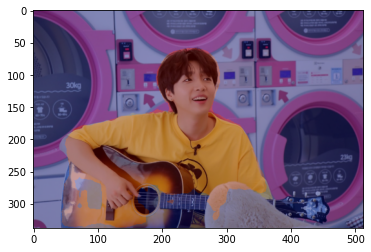

In [9]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

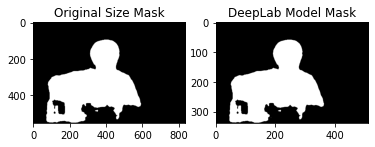

In [10]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

# 4. Apply the Bokeh Effect


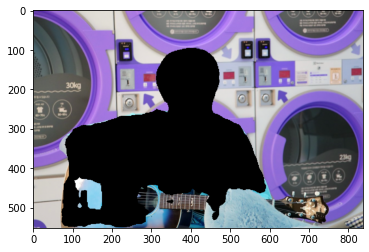

In [11]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

Le'ts blur this background_area

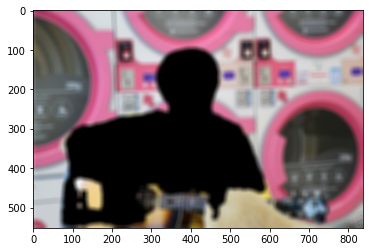

In [14]:
img_bg_blur = cv2.blur(img_bg, (15,15))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()


Then concatenate the blurred background image and the original image.

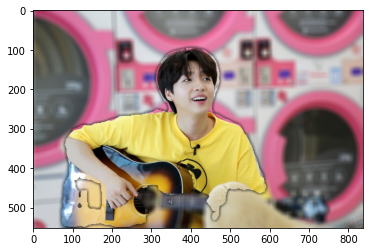

In [39]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 5. Let's Create a Chromakey Image

This is the background image I want.

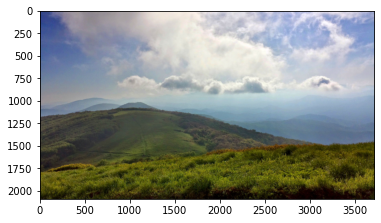

In [18]:
plt.imshow(cv2.cvtColor(background_orig, cv2.COLOR_BGR2RGB))

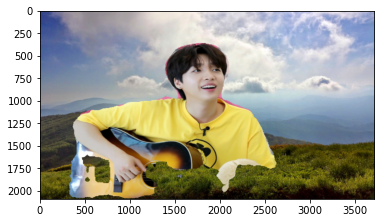

In [37]:
img_resized = cv2.resize(img_orig, (background_orig.shape[1], background_orig.shape[0]))
img_mask_resized = cv2.resize(img_mask_color, (background_orig.shape[1], background_orig.shape[0]))

background_concat = np.where(img_mask_resized == 255, img_resized, background_orig)

plt.imshow(cv2.cvtColor(background_concat, cv2.COLOR_BGR2RGB))
plt.show()


I can more clearly see that the part of the guitar is not recognized to be a part of his body, and also the blanket on his knee is disappeared.   
But still I was able to create a chromakey image.

#6. Run the model for a cat image

In [23]:
cat_resized, cat_seg_map = MODEL.run(cat_orig)
print(cat_orig.shape)
print(cat_resized.shape)

(360, 480, 3)
(384, 513, 3)


Let's check the original cat image.

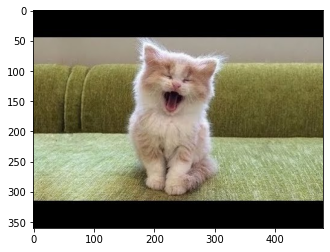

In [25]:
plt.imshow(cv2.cvtColor(cat_orig, cv2.COLOR_BGR2RGB))


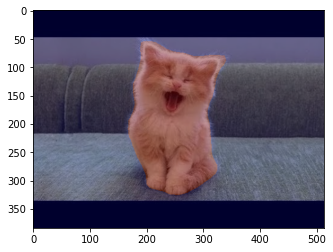

In [26]:
cat_img_show = cat_resized.copy()
cat_seg_map = np.where(cat_seg_map == 8, 8, 0)  # code to recognize the cat.
cat_img_mask = cat_seg_map * (255/cat_seg_map.max()) # 255 normalization
cat_img_mask = cat_img_mask.astype(np.uint8)
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()

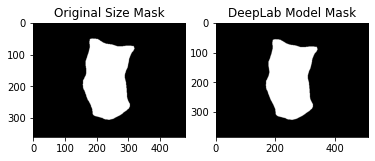

In [28]:
cat_img_mask_up = cv2.resize(cat_img_mask, cat_orig. shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_img_mask_up = cv2.threshold(cat_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(cat_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

Then Let's extract the background using segmentation mask.

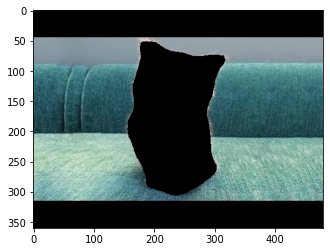

In [30]:
cat_img_mask_color = cv2.cvtColor(cat_img_mask_up, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg = cv2.bitwise_and(cat_orig, cat_img_bg_mask)
plt.imshow(cat_img_bg)
plt.show()

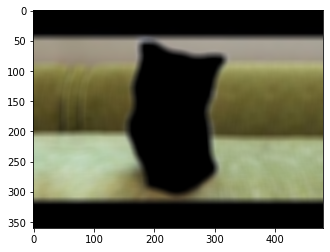

In [31]:
cat_img_bg_blur = cv2.blur(cat_img_bg, (13,13))
plt.imshow(cv2.cvtColor(cat_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

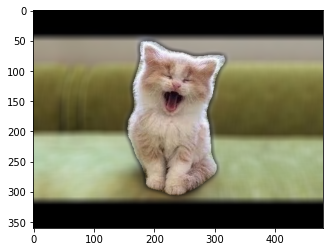

In [33]:
cat_img_concat = np.where(cat_img_mask_color==255, cat_orig, cat_img_bg_blur)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

Then let's try the same background image to this cat!

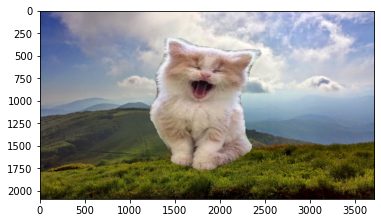

In [35]:
cat_img_resized = cv2.resize(cat_orig, (background_orig.shape[1], background_orig.shape[0]))
cat_img_mask_resized = cv2.resize(cat_img_mask_color, (background_orig.shape[1], background_orig.shape[0]))

cat_background_concat = np.where(cat_img_mask_resized == 255, cat_img_resized, background_orig)

plt.imshow(cv2.cvtColor(cat_background_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 7. Result

The portrait mode result:

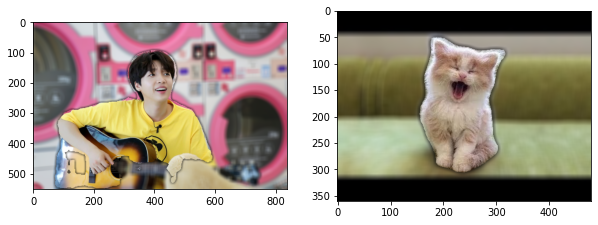

In [40]:
plt.figure(figsize=(10,20))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))

The Chromakey result:

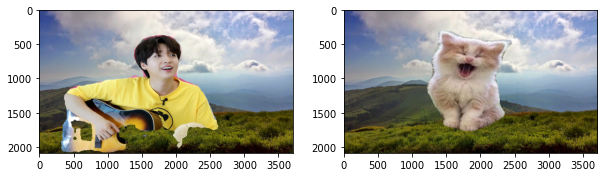

In [38]:
plt.figure(figsize=(10,20))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(background_concat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cat_background_concat, cv2.COLOR_BGR2RGB))


# 8. Limitations of Image Segmentation
Just like the guitar and his knee were not included as a part of the 'person', we can notice that `Semantic Segmentation` technique cannot detect the **depth** of the each part of the person.    
Inaccuracy in semantic segmentation causes several problems. Since the bokeh (out-focusing) effect using depth of field literally expresses the depth itself, it optically differentiates the focused distance very delicately except if the accuracy is 1.00.

To solve this issue, the possible solutions are:
1. Utilize 3D Depth Camera (multiple cameras)
2. Use Depth Image (Struct2Depth)
3. Use IR (Google's pixe4)

Further, I found we can do the `Depth Estimation` using a Single RGB Image using a Hybrid Convolutional
Neural Network.    
The feature-extraction process for a specific task is modeled as a parameter estimation problem in Convolutional Neural Networks (CNNs), and this provides a possibility of combining different depth estimation and semantic segmentation feature extractors. But unfortunately, I had no chance to implement this.   
Ref to this research paper: (Lin, Xiao, et al. “Depth Estimation and Semantic Segmentation from a Single RGB Image Using a Hybrid Convolutional Neural Network.” Sensors, vol. 19, no. 8, 2019, p. 1795., doi:10.3390/s19081795 )


# Conclusion
## Things I've learned
- More use cases with cv2 with Tensorflow-provided pre-trained weights and models.
- Use cases with `seg_map`.

## Challenges I've Faced
- There is a thin border line is observed after I cropped a person & cat from the original image. 
- I think this is occurred because the border between the "person/cat" segmentation and the concatenated background is separated as (0,1).
- Also, I noticed that Sewoon's guitar and the blanket on this knee were not masked as a **"person"**. Technically that is correct, but the users will expect to interpret his guitar and the blanket & his knee as a "**person**"

## What to do further
- In my understanding, the thin border is occurred because segmentation and the concatenated background is separated as (0,1), I can make it seamlessly by using improved segmentation method by smoothing the separation.

# References
Lin, Xiao, et al. “Depth Estimation and Semantic Segmentation from a Single RGB Image Using a Hybrid Convolutional Neural Network.” Sensors, vol. 19, no. 8, 2019, p. 1795., doi:10.3390/s19081795. 